In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style='whitegrid')

In [3]:
from google.cloud import bigquery
client = bigquery.Client()

Three types of Trips: FHV, Green and Yellow

In [4]:
sql = """
SELECT * FROM `bigquery-public-data.new_york_taxi_trips.tlc_fhv_trips_2015`
LIMIT 50000
"""
df_311 = client.query(sql).to_dataframe()


In [5]:
df = df_311

In [6]:
df.head()

,location_id,pickup_datetime,dispatching_base_num,borough,zone,service_zone
0,179.0,2015-12-17 08:50:04,B02617,Queens,Old Astoria,Boro Zone
1,226.0,2015-10-13 09:06:02,B02682,Queens,Sunnyside,Boro Zone
2,244.0,2015-12-08 21:15:24,B02836,Manhattan,Washington Heights South,Boro Zone
3,145.0,2015-10-09 19:12:21,B02510,Queens,Long Island City/Hunters Point,Boro Zone
4,228.0,2015-09-11 03:26:52,B02764,Brooklyn,Sunset Park West,Boro Zone


Formatting DateTime to get day, month, year, weekday.

In [7]:
df['pickup_datetime'] = df['pickup_datetime'].apply(str)

In [8]:
from datetime import datetime

In [9]:
df['pickup_datetime'][0][-8:][6:8] #0:2, 3:5, 6:8

'04'

In [10]:
time = []
day = []
month = []
year = []
weekday = []
hour = []
minut = []
second = []

for i in range(len(df)):
    tim = df['pickup_datetime'][i][-8:]
    t = datetime.strptime(df['pickup_datetime'][i], '%Y-%m-%d %H:%M:%S')
    day.append(t.day)
    month.append(t.month)
    year.append(t.year)
    weekday.append(t.weekday())
    
    time.append(tim)
    hour.append(int(tim[0:2]))
    minut.append(int(tim[3:5]))
    second.append(int(tim[6:8]))
    

In [11]:
df['time'] = time
df['day'] = day
df['month'] = month
df['year'] = year
df['day_of_week'] = weekday
df['hour'] = hour
df['minute'] = minut
df['second'] = second

**Plotting the Trips by the hours in a day**

In [12]:
hour_data = df.groupby('hour')['pickup_datetime'].count()

In [13]:
hour_data = pd.DataFrame(hour_data).reset_index()

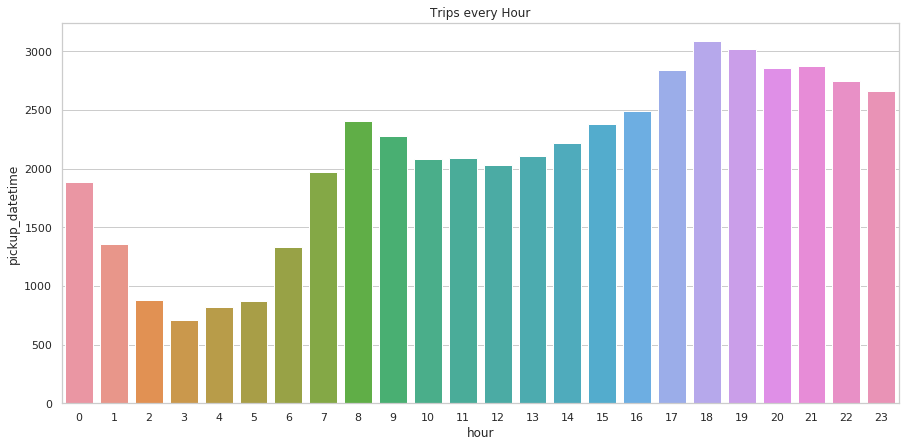

In [86]:
plt.figure(figsize=(15, 7))
sns.barplot(x='hour', y='pickup_datetime', data=hour_data)
plt.title('Trips every Hour')
plt.show()

In the sample data, we observe that there are more rides towards to end of the day compared to morning.

**Ploting the Trips by Hour and month**

In [25]:
month_hour = df.groupby(['month', 'hour']).size()
                .reset_index().pivot(columns='month', 
                                     index='hour', values=0)


In [33]:
month_hour.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
hour,,,,,,,,,,,,
0,78,99,127,112,134,121,126,153,197,247,228,266
1,48,62,69,75,109,91,115,111,120,168,202,188
2,44,35,48,57,64,58,58,82,84,130,110,109
3,39,29,33,29,55,58,45,49,61,96,101,115
4,33,36,45,44,42,67,40,86,86,96,124,123


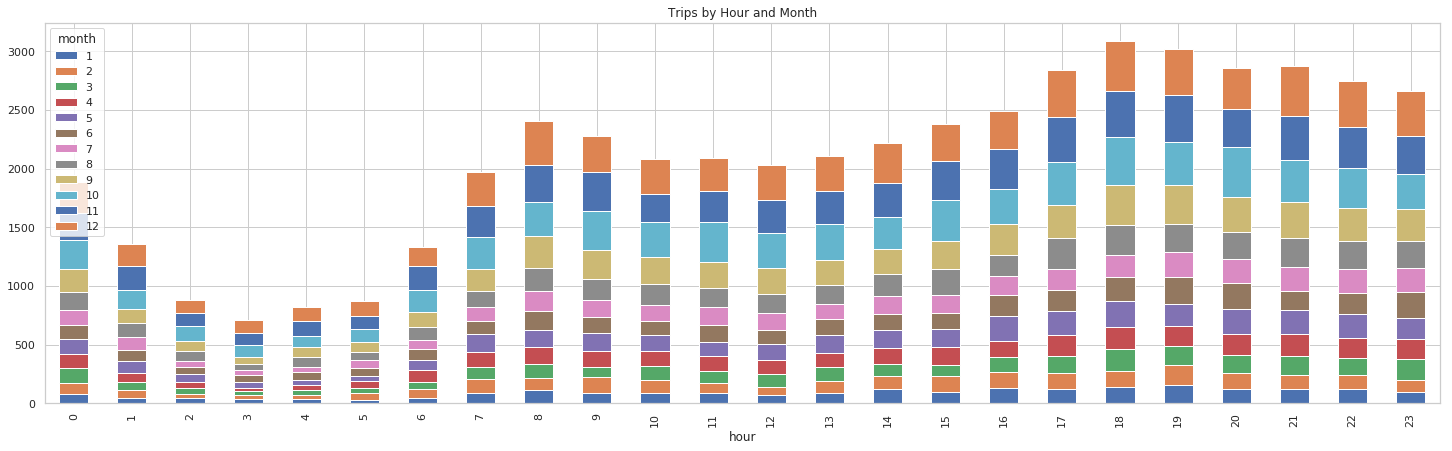

In [90]:
month_hour.plot(kind='bar', stacked=True, figsize=(25, 7))
plt.title('Trips by Hour and Month')
plt.show()

In the sample data, we observe a pattern of more rides occuring not only towards the end of Day but also towards the end of Year i.e. in the end months of the Year.

**Trips during every day of the month**

In [45]:
daywise = pd.DataFrame(df.groupby('day').size()).reset_index()
daywise.columns = ['day', 'count']

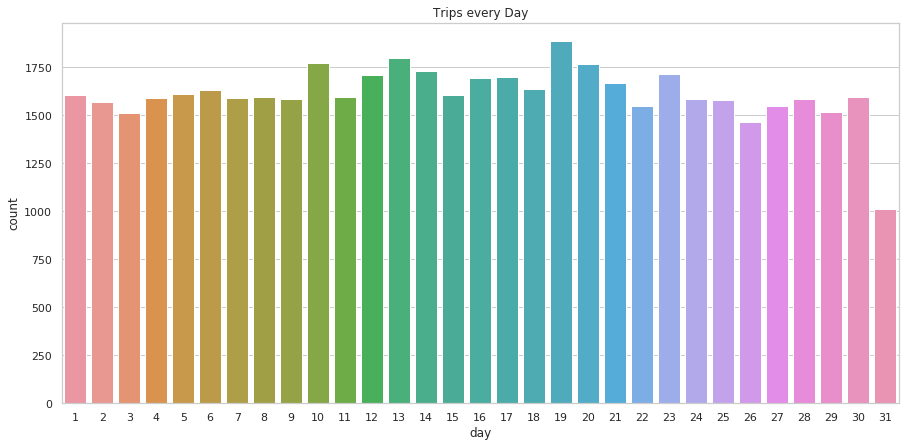

In [91]:
plt.figure(figsize=(15, 7))
sns.barplot(x='day', y='count', data=daywise)
plt.title('Trips every Day')
plt.show()

We see a rather continuous trend in the number of rides by day for the sample data. There isn't a big drop in the count except at the end of the month. 

**Trips by Day and month**

In [56]:
month_day = df.groupby(['day_of_week', 'month']).size()\
            .reset_index().pivot(columns='day_of_week', \
                                 index='month', values=0)


In [57]:
month_day.head()

day_of_week,0,1,2,3,4,5,6
month,,,,,,,
1,221,246,287,389,396,379,262
2,328,294,323,360,410,385,301
3,405,416,314,357,406,383,387
4,386,384,509,537,409,446,364
5,394,522,453,447,575,598,478


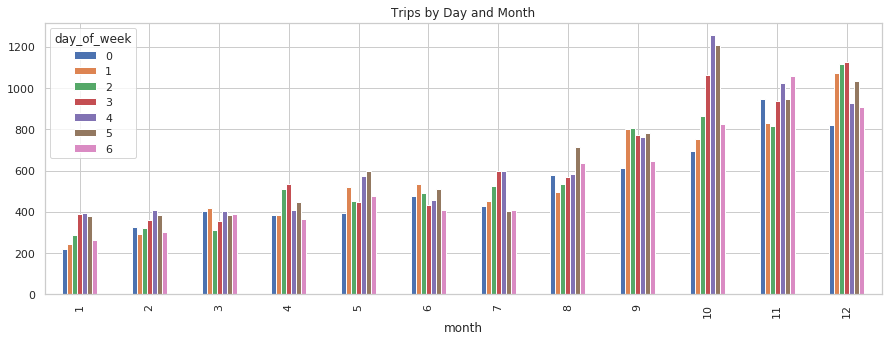

In [93]:
month_day.plot(kind='bar', figsize=(15, 5))
plt.title('Trips by Day and Month')
plt.show()

As observed earlier, the number of rides are more in the ending monthly starting from October. And we see a peak in the middle of the week.

**Number of Trips taking place during months in a year**

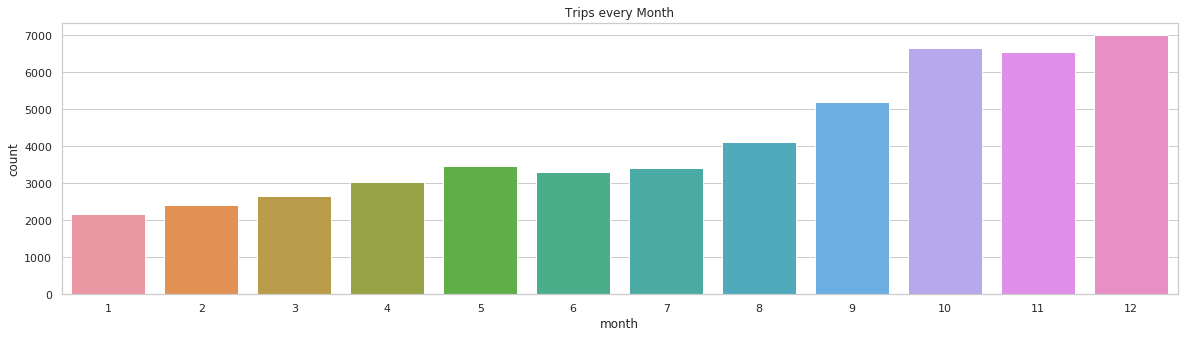

In [95]:
monthwise = df.groupby('month').size().reset_index()
monthwise.columns = ['month', 'count']

plt.figure(figsize=(20, 5))
sns.barplot(x='month', y='count', data=monthwise)
plt.title('Trips every Month')
plt.show()

**Heatmap Visualizations of Day, Hour, and Month**

In [72]:
day_hour_hm = df.groupby(['day', 'hour']).size().reset_index()
day_hour_hm.columns = ['day', 'hour', 'Total']

In [74]:
day_hour_hm = day_hour_hm.pivot('day', 'hour', 'Total')

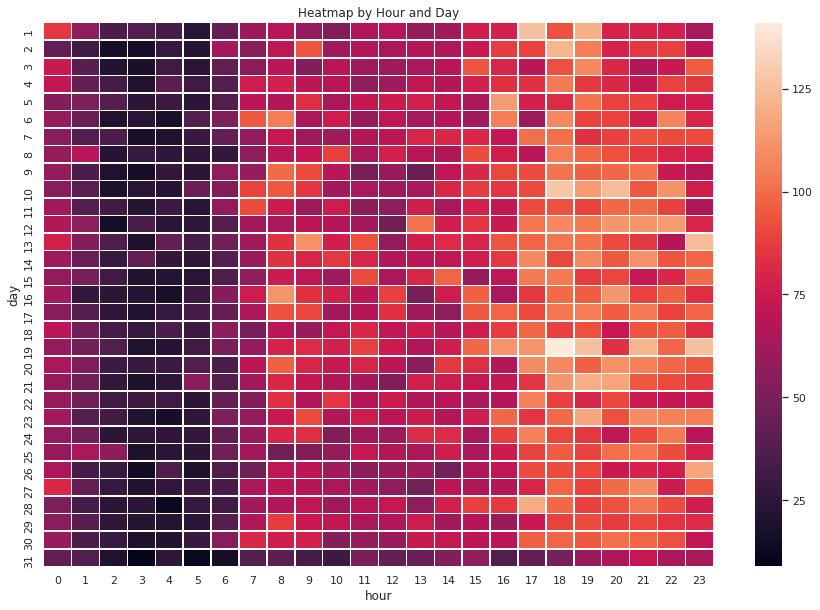

In [81]:
plt.figure(figsize=(15, 10))
sns.heatmap(day_hour_hm, linewidth=.5)
plt.title('Heatmap by Hour and Day')
plt.show()

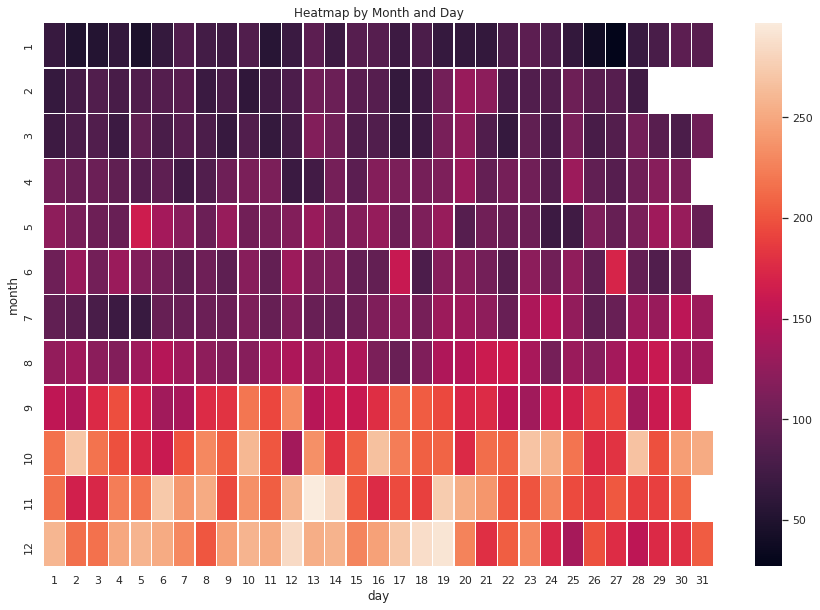

In [83]:
hm = df.groupby(['month', 'day']).size().reset_index()
hm.columns = ['month', 'day', 'Total']

hm = hm.pivot('month', 'day', 'Total')

plt.figure(figsize=(15, 10))
sns.heatmap(hm, linewidth=.5)
plt.title('Heatmap by Month and Day')
plt.show()

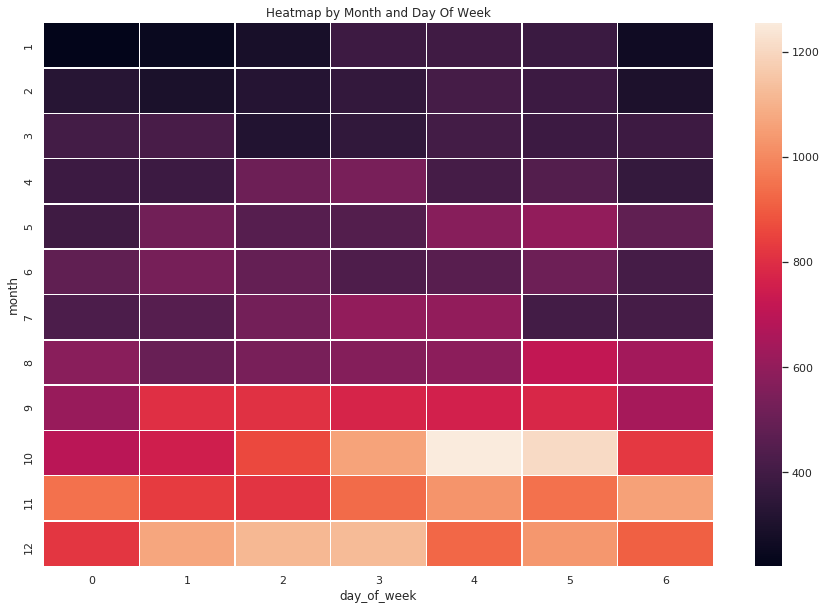

In [84]:
hm = df.groupby(['month', 'day_of_week']).size().reset_index()
hm.columns = ['month', 'day_of_week', 'Total']

hm = hm.pivot('month', 'day_of_week', 'Total')

plt.figure(figsize=(15, 10))
sns.heatmap(hm, linewidth=.5)
plt.title('Heatmap by Month and Day Of Week')
plt.show()